In [42]:
import pandas as pd
import numpy as np
import os
import json
import re
import csv
import string
import nltk
import ast
import re
import warnings
import matplotlib.pyplot as plt

In [146]:
from tqdm import tqdm_notebook as tqdm
from pymystem3 import Mystem
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from scipy.sparse import hstack, vstack
from scipy import sparse
from tqdm.notebook import tqdm

In [3]:
RESOURCES_PATH = os.path.join(os.pardir, 'resources')

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/itukh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /home/itukh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/itukh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data = pd.read_csv(os.path.join(RESOURCES_PATH, 'all_train.csv'))

In [6]:
data.head()

,Text,Score,FinalScore1,Category
0,Оригинал взят у в Заложен пятый фрегат проекта...,"[1, 0, 0]",0,Post
1,Бодхисаттва устранения всяческой ущербности (С...,[0],0,Post
2,Выпущено два минометных снаряда. Несколько мин...,[-1],-1,Post
3,В пригороде Дамаска Джобар во время преследова...,[0],0,Post
4,Тема пенсионных реформ оказалась настолько жив...,"[0, 0, 0]",0,Post


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29442 entries, 0 to 29441
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         29442 non-null  object
 1   Score        29442 non-null  object
 2   FinalScore1  29442 non-null  int64 
 3   Category     29442 non-null  object
dtypes: int64(1), object(3)
memory usage: 920.2+ KB


In [8]:
data.groupby("Category").count()

,Text,Score,FinalScore1
Category,,,
Comment,12738,12738,12738
Post,16704,16704,16704


In [9]:
processed_data_path = os.path.join(RESOURCES_PATH, 'processed_data.csv')
pd.read_csv(processed_data_path).head()

,Text,Score,FinalScore1,Category,! freq,) freq,:) freq,=) freq,( freq,:( freq,...,adjectives percent,verbs percent,emotional verbs,obscene words,average word length,exclamation mark count,question mark count,lemmas,average word sentiment,post
0,Оригинал взят у в Заложен пятый фрегат проекта...,"[1, 0, 0]",0,Post,0,0,0,0,0,0,...,0.152542,0.084746,0,0,6.559322,0,0,"['оригинал', 'взять', 'закладывать', 'пятый', ...",0.000000,1
1,Бодхисаттва устранения всяческой ущербности (С...,[0],0,Post,0,0,0,0,0,0,...,0.128655,0.134503,0,0,5.725146,0,0,"['бодхисаттва', 'устранение', 'всяческий', 'ущ...",0.020833,1
2,Выпущено два минометных снаряда. Несколько мин...,[-1],-1,Post,0,0,0,0,0,0,...,0.145455,0.090909,0,1,5.872727,0,0,"['выпускать', 'минометный', 'снаряд', 'несколь...",-0.050000,1
3,В пригороде Дамаска Джобар во время преследова...,[0],0,Post,0,0,0,0,0,0,...,0.087432,0.114754,0,2,5.885246,0,0,"['пригород', 'дамаск', 'джобар', 'время', 'пре...",-0.039370,1
4,Тема пенсионных реформ оказалась настолько жив...,"[0, 0, 0]",0,Post,0,0,0,0,0,0,...,0.075000,0.162500,0,0,5.087500,0,0,"['тема', 'пенсионный', 'реформа', 'оказываться...",0.023810,1


In [10]:
def load_obscene_words():
    with open(os.path.join(RESOURCES_PATH, 'obscene_words.txt'), 'r') as word_file:
        words = word_file.read().replace(',', ' ').lower()
        tokens = word_tokenize(words)
        obscene = set(tokens)
        obscene.remove('на')
        obscene.remove('не')
        obscene.remove('сила')
        return obscene

In [11]:
def load_emotional_verbs():
    emotional_words = pd.read_csv(os.path.join(RESOURCES_PATH, 'verbs_emotional.csv'))
    trusted = emotional_words[emotional_words['emotional'] == '+']
    return set(trusted['verb'].apply(lambda word: word_tokenize(word.lower())[0]).to_numpy())

In [12]:
def load_words_sentiment_dictionary():
    dictionary_path = os.path.join(RESOURCES_PATH, 'words_all_full_rating_utf_8.csv')
    words_sentiment = {}
    with open(dictionary_path) as dict_file:
        sentiment_reader = csv.DictReader(dict_file, delimiter=';', quotechar='"')
        for sentiment_row in sentiment_reader:
            word = sentiment_row['Words']
            words_sentiment[word] = float(sentiment_row['average rate'])

    return words_sentiment

def get_word_sentiment(sentiment_dict, word):
    return 0.0 if word not in sentiment_dict else sentiment_dict[word]

In [71]:
def has_uppercase_word(text):
    for token in text.split(' '):
        if token.isupper() and len(token) > 1:
            return 1
    return 0

def get_pos_percent(pos_predicate, poses):
    try:
        parsed_poses = ast.literal_eval(poses)
    except:
        parsed_poses = poses
    pos_count = len([1 for p in parsed_poses if pos_predicate(p[1])])
    return 1. * pos_count / len(parsed_poses)

def get_dictionary_count(poses, dictionary):
    try:
        parsed_poses = ast.literal_eval(poses)
    except:
        parsed_poses = poses
    return len([1 for p in parsed_poses if p in dictionary])

def get_average_word_length(tokens):
    try:
        parsed_tokens = ast.literal_eval(tokens)
    except:
        parsed_tokens = tokens
    return np.mean(list(map(len, parsed_tokens)))

def get_lemmas(text, mystem, stop_words):
    # text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = mystem.lemmatize(text.lower())
    return [token for token in tokens if token not in stop_words and token != " "
            and token.strip() not in string.punctuation]

def get_sentiment(sentiment_dict, lemmas):
    try:
        parsed_lemmas = ast.literal_eval(lemmas)
    except:
        parsed_lemmas = lemmas
    return np.mean([get_word_sentiment(sentiment_dict, word) for word in parsed_lemmas])

class TextualFeaturesExtracter:
    def __init__(self, data):
        self.data = data.copy()
        self.X = None
        self.y = None
        self.scores = None
        self.emotional_verbs = load_emotional_verbs()
        self.obscene_words = load_obscene_words()
        self.sentiment_dict = load_words_sentiment_dictionary()
        self.mystem = Mystem()
        self.stop_words = set(stopwords.words("russian"))
        self._build_data()
        
    def _build_data(self):
        processed_data_path = os.path.join(RESOURCES_PATH, 'processed_data.csv')
        if not os.path.exists(processed_data_path):
            self.data['! freq'] = self.data['Text'].apply(lambda x: x.count('!'))

            # ':‑\)' and ':‑\(' do not appear in the train dataset
            for emoticon in ['\) ', ':\)', '=\)', '\( ', ':\(', '=\(']:
                emoticon_str = emoticon.replace('\\', '')
                self.data[f'{emoticon_str} freq'] = self.data['Text'].apply(lambda x: len(re.findall(rf'{emoticon}', x)))

            self.data['upper case'] = self.data['Text'].apply(has_uppercase_word)
            self.data['tokens'] = self.data['Text'].apply(lambda text: word_tokenize(text.lower()))
            self.data['pos'] = self.data['tokens'].apply(lambda tokens: pos_tag(tokens, lang='rus'))
            
            self.data['lemmas'] = self.data['Text'].apply(
                lambda text: get_lemmas(text, self.mystem, self.stop_words))
            
            self.data['nouns percent'] = self.data['pos'].apply(
                lambda poses: get_pos_percent(lambda p: p == 'S', poses))
            self.data['adjectives percent'] = self.data['pos'].apply(
                lambda poses: get_pos_percent(lambda p: p[0] == 'A' and (len(p) == 1 or p[1] == '='), poses))
            self.data['verbs percent'] = self.data['pos'].apply(
                lambda poses: get_pos_percent(lambda p: p == 'V', poses))
            self.data['exclamation mark count'] = self.data['Text'].apply(
                lambda text: text.count('!'))
            self.data['question mark count'] = self.data['Text'].apply(
                lambda text: text.count('?'))
            self.data['emotional verbs'] = self.data['lemmas'].apply(
                lambda p: get_dictionary_count(p, self.emotional_verbs))
            self.data['obscene words'] = self.data['tokens'].apply(
                lambda p: get_dictionary_count(p, self.obscene_words))
            self.data['average word length'] = self.data['tokens'].apply(
                get_average_word_length)
            self.data['average word sentiment'] = self.data['lemmas'].apply(
                lambda lemmas: get_sentiment(self.sentiment_dict, lemmas))
            # self.data['post'] = self.data['Category'].apply(
            #    lambda c: 1 if c == 'Post' else 0)

            with open(processed_data_path, 'w') as csv_file:
                csv_file.write(self.data.to_csv(index=False))    
        
        self.processed_data = pd.read_csv(processed_data_path)
        # with open(processed_data_path, 'w') as csv_file:
        #         csv_file.write(self.processed_data.to_csv(index=False))
        
        self.scores = self.processed_data['Score'].apply(json.loads)
        self.y = self.processed_data['FinalScore1'].to_numpy()
        self.X = self.processed_data.copy().drop(columns=['Text', 'FinalScore1', 'Score',
                                                         'tokens', 'lemmas', 'pos', 'Category'])
    
    def get_Xy(self):
        return self.X, self.y
    
    def get_scores(self):
        return self.scores
    
    def get_texts(self):
        return self.data['Text'].to_numpy()

In [72]:
builder = TextualFeaturesExtracter(data)
X, y = builder.get_Xy()
texts = builder.get_texts()

In [73]:
X.head()

,! freq,) freq,:) freq,=) freq,( freq,:( freq,=( freq,upper case,nouns percent,adjectives percent,verbs percent,emotional verbs,obscene words,average word length,exclamation mark count,question mark count,average word sentiment
0,0,0,0,0,0,0,0,1,0.389831,0.152542,0.084746,0,0,6.559322,0,0,0.000000
1,0,0,0,0,0,0,0,0,0.257310,0.128655,0.134503,0,0,5.725146,0,0,0.020833
2,0,0,0,0,0,0,0,0,0.400000,0.145455,0.090909,0,1,5.872727,0,0,-0.050000
3,0,0,0,0,0,0,0,1,0.453552,0.087432,0.114754,0,2,5.885246,0,0,-0.039370
4,0,0,0,0,0,0,0,0,0.175000,0.075000,0.162500,0,0,5.087500,0,0,0.023810


In [75]:
X_copy = X.copy()
X_copy['Score'] = y
X_copy.corr()['Score']

! freq                    0.009740
)  freq                   0.044400
:) freq                   0.082639
=) freq                   0.014004
(  freq                  -0.024778
:( freq                  -0.008754
=( freq                  -0.007619
upper case               -0.029577
nouns percent             0.021243
adjectives percent        0.075599
verbs percent            -0.090302
emotional verbs          -0.034599
obscene words            -0.029389
average word length       0.005102
exclamation mark count    0.009740
question mark count      -0.003116
average word sentiment    0.306098
Score                     1.000000
Name: Score, dtype: float64

In [76]:
np.unique(y, return_counts=True)

(array([-1,  0,  1]), array([12436, 14723,  2283]))

In [77]:
RANDOM_STATE = 23923

In [78]:
warnings.filterwarnings('ignore')

In [79]:
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(X, y, texts, test_size=0.2, 
                                                            shuffle=True, random_state=RANDOM_STATE)

In [80]:
plt.rcParams['figure.figsize'] = (20, 20)

In [81]:
def train_logistic_regression(X_, y_, params=None, max_iter=2000):
    params = {
        'class_weight' : 'balanced',
        'random_state' : RANDOM_STATE
    } if params is None else params
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_, y_, test_size=0.2, shuffle=True,
                                                         random_state=RANDOM_STATE)
    params.update({'warm_start' : True,
                   'max_iter' : 1})
    clf = LogisticRegression(**params)
    train_scores = []
    val_scores = []
    for _ in tqdm(range(max_iter)):
        clf.fit(X_train_, y_train_)
        train_scores.append(f1_score(y_train_, clf.predict(X_train_), average='macro'))
        val_scores.append(f1_score(y_val_, clf.predict(X_val_), average='macro'))
    
    iterations = range(1, max_iter + 1)
    plt.clf()
    plt.plot(iterations, train_scores, label='train macro F1')
    plt.plot(iterations, val_scores, label='validation maco F1')
    plt.xlabel('Iterations')
    plt.ylabel('F1 macro')
    plt.legend()
    plt.show()
    
    params.update({'warm_start' : False,
                   'max_iter' : np.argmax(val_scores) + 1})
    return LogisticRegression(**params).fit(X_, y_)

## Basic Logistic Regression Model

In [95]:
clf0 = train_logistic_regression(X_train, y_train, max_iter=2000)
print('Train accuracy:', clf0.score(X_train, y_train))
print('Train macro F1:', f1_score(y_train, clf0.predict(X_train), average='macro'))
print('Test accuracy:', clf0.score(X_test, y_test))
print('Test macro F1:', f1_score(y_test, clf0.predict(X_test), average='macro'))

Train accuracy: 0.4899588162866726
Train macro F1: 0.4455036716409146
Test accuracy: 0.48650025471217523
Test macro F1: 0.43427226285717485


## Basic Logistic Regression Model + TF-IDF

In [96]:
vectorizer = TfidfVectorizer(
    # sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    # stop_words=stopwords.words("russian"),
    # ngram_range=(2, 3),
    max_features=10000)
X_texts_train = vectorizer.fit_transform(texts_train)
X_texts_test = vectorizer.transform(texts_test)

In [97]:
X_train_combined = sparse.hstack((sparse.csr_matrix(X_train.to_numpy().astype('float')), X_texts_train.toarray()))
X_test_combined = sparse.hstack((sparse.csr_matrix(X_test.to_numpy().astype('float')), X_texts_test.toarray()))

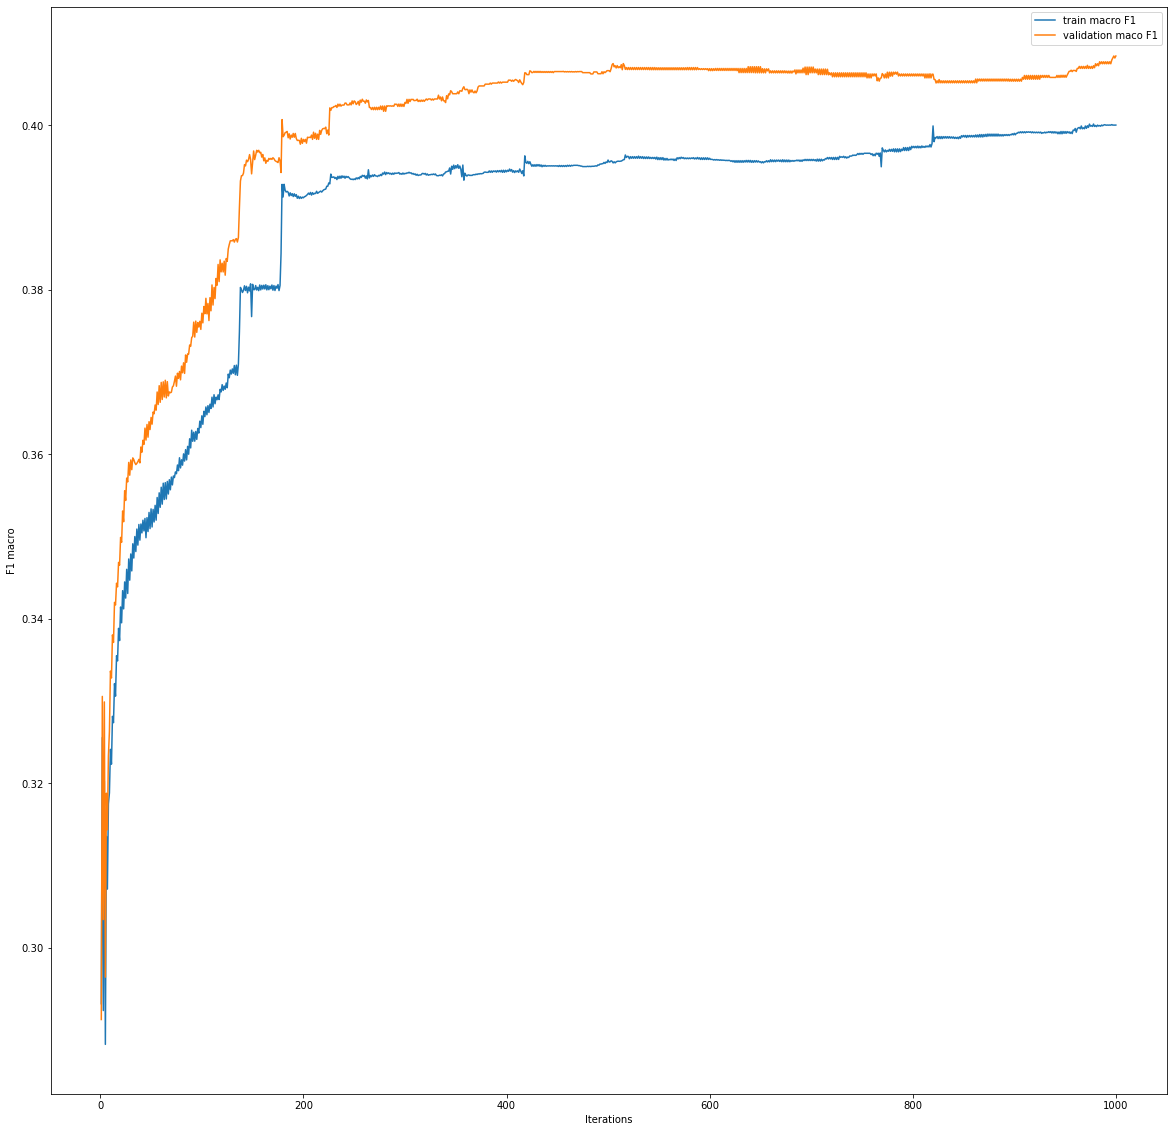

Train accuracy: 0.6971935634526387
Train macro F1: 0.6669526713313312
Test accuracy: 0.5773475972151468
Test macro F1: 0.5034624155927917


In [98]:
clf1 = train_logistic_regression(X_train_combined, y_train, max_iter=1000)
print('Train accuracy:', clf1.score(X_train_combined, y_train))
print('Train macro F1:', f1_score(y_train, clf1.predict(X_train_combined), average='macro'))
print('Test accuracy:', clf1.score(X_test_combined, y_test))
print('Test macro F1:', f1_score(y_test, clf1.predict(X_test_combined), average='macro'))

## Experiments section

In [101]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words=stopwords.words("russian"),
    ngram_range=(2, 4),
    max_features=10000)
X_char_train = char_vectorizer.fit_transform(texts_train)
X_char_test = char_vectorizer.fit_transform(texts_test)

In [102]:
X_train_combined_1 = sparse.hstack((X_train_combined, X_char_train.toarray()))
X_test_combined_1 = sparse.hstack((X_test_combined, X_char_test.toarray()))

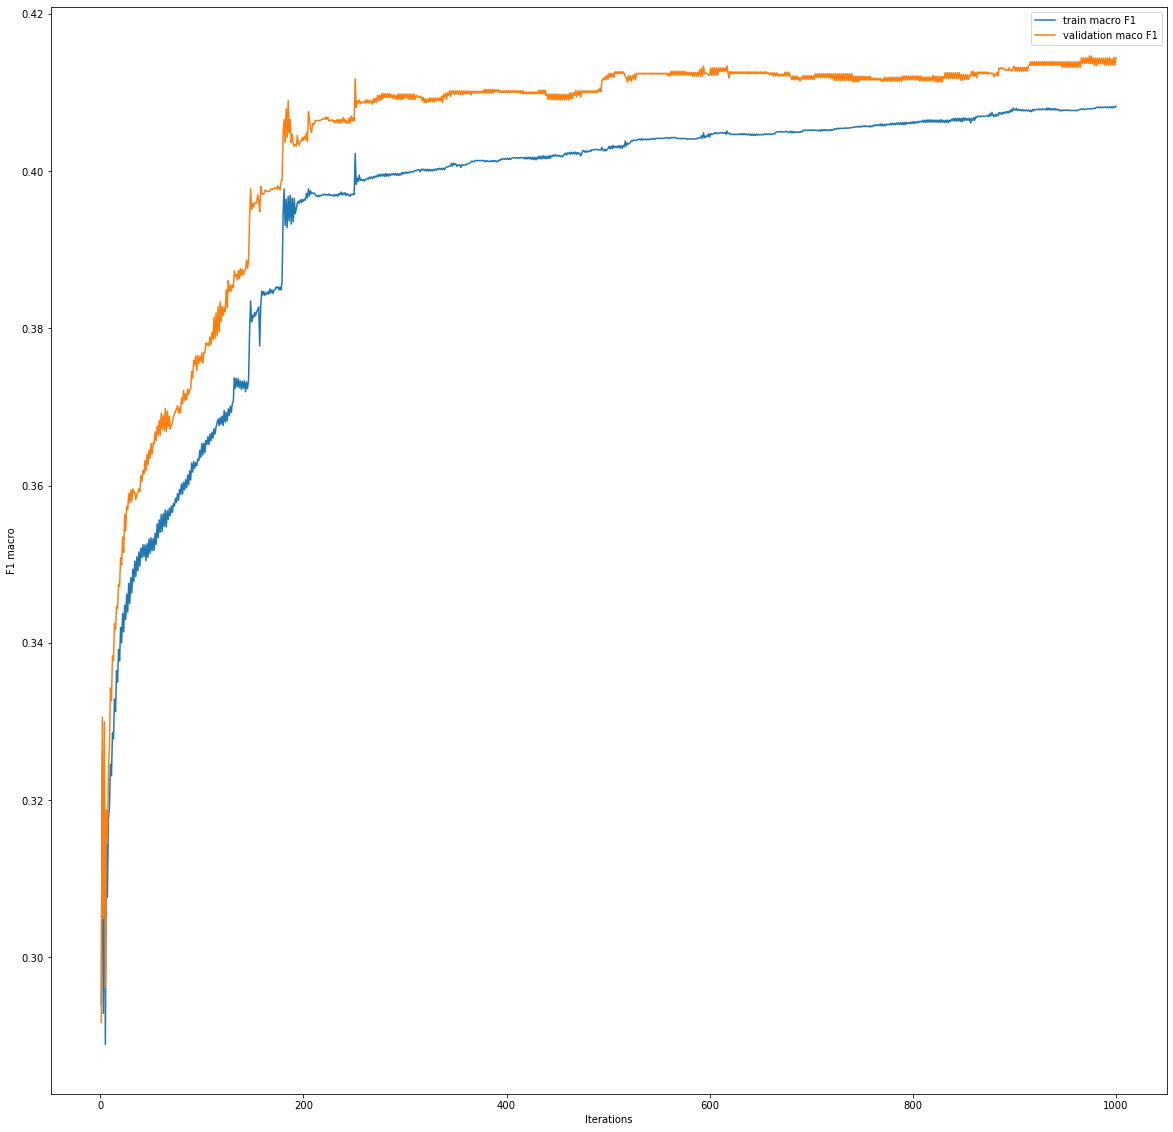

In [92]:
clf2 = train_logistic_regression(X_train_combined_1, y_train, max_iter=1000)

In [104]:
print('Train accuracy:', clf2.score(X_train_combined_1, y_train))
print('Train macro F1:', f1_score(y_train, clf2.predict(X_train_combined_1), average='macro'))
print('Test accuracy:', clf2.score(X_test_combined_1, y_test))
print('Test macro F1:', f1_score(y_test, clf2.predict(X_test_combined_1), average='macro'))

Train accuracy: 0.7371035536874283
Train macro F1: 0.7163439721164161
Test accuracy: 0.5257259296994397
Test macro F1: 0.36137898467500995


### NBC

In [124]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(
        use_idf=True,
        sublinear_tf=False)),
    ('clf', MultinomialNB(alpha=1, fit_prior=True)),
])

In [125]:
text_clf.fit(texts_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=1))])

In [126]:
print('Train accuracy:', text_clf.score(texts_train, y_train))
print('Train macro F1:', f1_score(y_train, text_clf.predict(texts_train), average='macro'))
print('Test accuracy:', text_clf.score(texts_test, y_test))
print('Test macro F1:', f1_score(y_test, text_clf.predict(texts_test), average='macro'))

Train accuracy: 0.7625355581030018
Train macro F1: 0.5312769669690561
Test accuracy: 0.6187807777211751
Test macro F1: 0.4186610628117567


### SVM

In [137]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto', degree=5))
svc.fit(X_train, y_train)
print('Train accuracy:', svc.score(X_train, y_train))
print('Train macro F1:', f1_score(y_train, svc.predict(X_train), average='macro'))
print('Test accuracy:', svc.score(X_test, y_test))
print('Test macro F1:', f1_score(y_test, svc.predict(X_test), average='macro'))

Train accuracy: 0.6052732136033626
Train macro F1: 0.45926775187148
Test accuracy: 0.5907624384445577
Test macro F1: 0.42810261929232846


In [139]:
svc = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', degree=5))
svc.fit(X_train_combined, y_train)
print('Train accuracy:', svc.score(X_train_combined, y_train))
print('Train macro F1:', f1_score(y_train, svc.predict(X_train_combined), average='macro'))
print('Test accuracy:', svc.score(X_test_combined, y_test))
print('Test macro F1:', f1_score(y_test, svc.predict(X_test_combined), average='macro'))

Train accuracy: 0.8954697915339872
Train macro F1: 0.8068300834192236
Test accuracy: 0.6140261504499915
Test macro F1: 0.4596398030073936


## Scores section:

In [141]:
X_combined = sparse.vstack((X_train_combined, X_test_combined))
y_combined = np.concatenate([y_train, y_test])

In [148]:
cross_val_score(clone(clf1), X_combined, y_combined, cv=5,
                scoring=lambda c, x_, y_: f1_score(y_, c.predict(x_), average='macro'))

array([0.51089436, 0.52419435, 0.51041661, 0.50947586, 0.50891846])

In [149]:
cross_val_score(clone(text_clf), texts, y, cv=5,
                scoring=lambda c, x_, y_: f1_score(y_, c.predict(x_), average='macro'))

array([0.39569987, 0.39300311, 0.41055647, 0.42965878, 0.41318603])

In [ ]:
cross_val_score(clone(svc), X_combined, y_combined, cv=5,
                scoring=lambda c, x_, y_: f1_score(y_, c.predict(x_), average='macro'))